# **SVHN Classification using PyTorch Image Models**
In this notebook, we train three models on The Street View House Numbers (SVHN) Dataset using  PyTorch Image Models (timm) module. 

_Brief Description and Overview of the SVHN Dataset_

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Overview:

*  10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
* 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
* Comes in two formats:
  1. Original images with character level bounding boxes.
  2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

(Source: http://ufldl.stanford.edu/housenumbers)

In [1]:
# Load the necessary libraries
!pip install timm
import timm
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

**Load the SVHN dataset using torchvision**

Note: In this dataset, '0' has a label 0 instead of 10

In [2]:
# Download our datasets and apply transforms using the torchvision module
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transform = {'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/SVHN'
image_datasets = {x: datasets.SVHN(os.path.join(data_dir, x), split = x, transform = data_transform[x], download = True)
              for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 128,
                                             shuffle = True, num_workers = 0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print("Train dataset:", dataset_sizes['train'])
print("Test dataset:", dataset_sizes['test'])

class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Configure device to use GPU when available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using downloaded and verified file: data/SVHN/train/train_32x32.mat
Using downloaded and verified file: data/SVHN/test/test_32x32.mat
Train dataset: 73257
Test dataset: 26032


**Visualize sample images from the datasets**

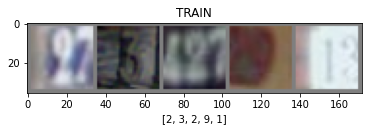

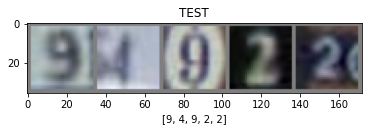

In [3]:
def imshow(input, title, label = ''):
    input = input.numpy().transpose((1, 2, 0))
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title.upper())
    plt.xlabel(label)
    plt.show()

num_samples = 5 # number of sample images to show
for x in ['train', 'test']:  
  # Get samples of data
  inputs, classes = next(iter(dataloaders[x]))
  # Make a grid using a number of samples (num_samples) from batch 
  out = torchvision.utils.make_grid(inputs[:num_samples], nrow  = num_samples)
  imshow(out, title = x, label = [class_names[name] for name in classes[:num_samples]])

**Train the model**

In this section, we write a function to train the model, track statistics and save the best model.

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc = []
    train_loss = []
    validation_acc = []
    validation_loss = []
    time_hist = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs), end = " | ")
        epoch_start_time = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                    'Train', epoch_loss, epoch_acc), end = " | ")
            else:
                validation_loss.append(epoch_loss)
                validation_acc.append(epoch_acc)
                print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                    'Valid', epoch_loss, epoch_acc), end = " | ")
                if epoch_acc > best_acc:
                  # deep copy the model
                  best_acc = epoch_acc
                  best_model_weights = copy.deepcopy(model.state_dict())    
        time_epoch = time.time() - epoch_start_time
        print('{:.0f}m {:.0f}s'.format(time_epoch // 60, time_epoch % 60))
        time_hist.append(time_epoch)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model, train_acc, train_loss, validation_acc, validation_loss, time_hist

**Plot data**

In this section, we write a function to plot historical data of loss and accuracy, and to create a confusion matrix of our model.

In [5]:
import pandas as pd
import seaborn as sns
def plot_stat(model, epochs, train_acc, train_loss, validation_acc, validation_loss):
  plt.plot(range(1, epochs + 1), train_acc, color = 'y', label = 'Training acc')
  plt.plot(range(1, epochs + 1), validation_acc, color = 'r', label = 'Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(range(1, epochs + 1), train_loss, color = 'y', label = 'Training loss')
  plt.plot(range(1, epochs + 1), validation_loss, color = 'r', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  nb_classes = len(class_names)
  confusion_matrix = np.zeros((nb_classes, nb_classes))
  with torch.no_grad():
      for inputs, labels in dataloaders['test']:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(labels.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

  plt.figure(figsize=(10,5))
  plt.title('Confusion Matrix')
  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap = 'Blues')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

#**Model 1:  Resnet-18**
Let us now load, train  and evaluate our first model, a pretrained ResNet-18 model.

Epoch 1/25 | Train Loss: 1.9527 Accuracy: 0.3202 | Valid Loss: 1.6194 Accuracy: 0.4410 | 0m 38s
Epoch 2/25 | Train Loss: 1.3835 Accuracy: 0.5278 | Valid Loss: 1.1841 Accuracy: 0.6013 | 0m 38s
Epoch 3/25 | Train Loss: 1.0519 Accuracy: 0.6418 | Valid Loss: 0.9298 Accuracy: 0.6888 | 0m 39s
Epoch 4/25 | Train Loss: 0.8528 Accuracy: 0.7132 | Valid Loss: 0.7910 Accuracy: 0.7377 | 0m 39s
Epoch 5/25 | Train Loss: 0.7268 Accuracy: 0.7558 | Valid Loss: 0.6844 Accuracy: 0.7769 | 0m 39s
Epoch 6/25 | Train Loss: 0.6677 Accuracy: 0.7782 | Valid Loss: 0.6855 Accuracy: 0.7783 | 0m 39s
Epoch 7/25 | Train Loss: 0.6558 Accuracy: 0.7823 | Valid Loss: 0.6770 Accuracy: 0.7805 | 0m 39s
Epoch 8/25 | Train Loss: 0.6473 Accuracy: 0.7835 | Valid Loss: 0.6674 Accuracy: 0.7820 | 0m 40s
Epoch 9/25 | Train Loss: 0.6401 Accuracy: 0.7867 | Valid Loss: 0.6599 Accuracy: 0.7849 | 0m 40s
Epoch 10/25 | Train Loss: 0.6322 Accuracy: 0.7895 | Valid Loss: 0.6508 Accuracy: 0.7881 | 0m 39s
Epoch 11/25 | Train Loss: 0.6279 Accura

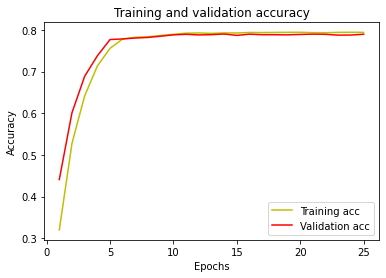

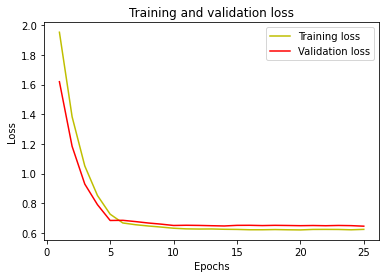

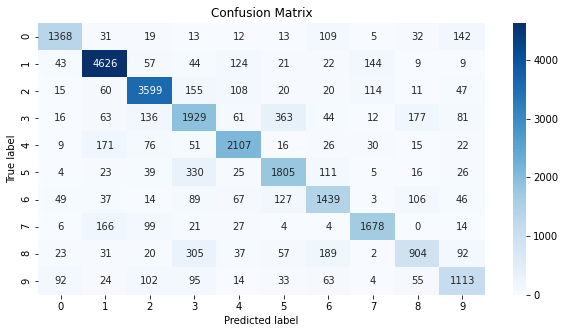

In [6]:
# Load a pretrained model
model_resnet18 = timm.create_model('resnet18', pretrained = True)

# Reset final fully connected layer and change the output size to 10
num_ftrs = model_resnet18.fc.in_features
num_output = 10
model_resnet18.fc = nn.Linear(num_ftrs, num_output)

model_resnet18 = model_resnet18.to(device)

# Use CrossEntropyLoss as criterion
criterion = nn.CrossEntropyLoss()
# Use SGD to optimize all parameters 
optimizer = optim.SGD(model_resnet18.parameters(), lr = 0.001)
# Decay LR by a factor of 0.1 every 5 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

epochs = 25
model_resnet18, train_acc, train_loss, validation_acc, validation_loss, time_hist = train_model(model_resnet18, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)
plot_stat(model_resnet18, epochs, train_acc, train_loss, validation_acc, validation_loss)

#**Model 2: DenseNet-121**
Let us now load, train  and evaluate our second model, a pretrained DenseNet-121 model.

Epoch 1/25 | Train Loss: 2.2619 Accuracy: 0.2225 | Valid Loss: 2.0199 Accuracy: 0.3152 | 1m 1s
Epoch 2/25 | Train Loss: 1.7754 Accuracy: 0.3924 | Valid Loss: 1.6325 Accuracy: 0.4489 | 1m 1s
Epoch 3/25 | Train Loss: 1.4619 Accuracy: 0.5046 | Valid Loss: 1.3271 Accuracy: 0.5653 | 1m 0s
Epoch 4/25 | Train Loss: 1.2336 Accuracy: 0.5851 | Valid Loss: 1.1081 Accuracy: 0.6378 | 1m 1s
Epoch 5/25 | Train Loss: 1.0542 Accuracy: 0.6472 | Valid Loss: 0.9610 Accuracy: 0.6871 | 1m 1s
Epoch 6/25 | Train Loss: 0.9141 Accuracy: 0.6972 | Valid Loss: 0.8455 Accuracy: 0.7275 | 1m 1s
Epoch 7/25 | Train Loss: 0.8046 Accuracy: 0.7358 | Valid Loss: 0.7389 Accuracy: 0.7663 | 1m 1s
Epoch 8/25 | Train Loss: 0.7128 Accuracy: 0.7686 | Valid Loss: 0.6700 Accuracy: 0.7890 | 1m 0s
Epoch 9/25 | Train Loss: 0.6424 Accuracy: 0.7926 | Valid Loss: 0.6152 Accuracy: 0.8079 | 1m 0s
Epoch 10/25 | Train Loss: 0.5816 Accuracy: 0.8126 | Valid Loss: 0.5554 Accuracy: 0.8280 | 1m 0s
Epoch 11/25 | Train Loss: 0.5509 Accuracy: 0.8235

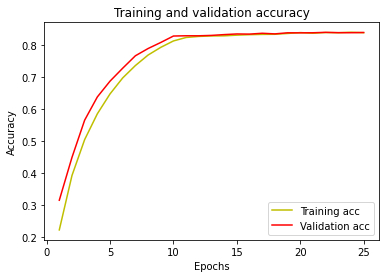

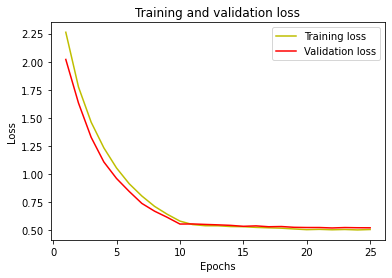

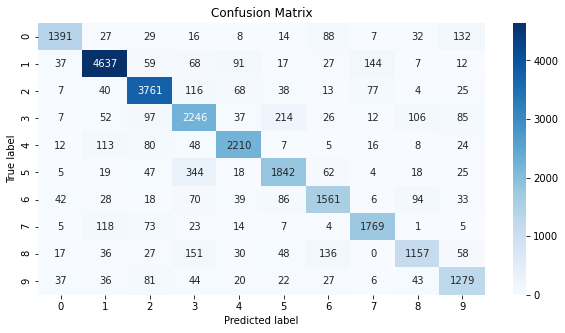

In [7]:
# Load a pretrained model
model_densenet121 = timm.create_model('densenet121', pretrained = True)

# Reset final fully connected layer and change the output size to 10
num_ftrs = model_densenet121.classifier.in_features
num_output = 10
model_densenet121.classifier = nn.Linear(num_ftrs, num_output)

model_densenet121 = model_densenet121.to(device)

# Use CrossEntropyLoss as criterion
criterion = nn.CrossEntropyLoss()
# Use SGD to optimize all parameters 
optimizer = optim.SGD(model_densenet121.parameters(), lr = 0.001)
# Decay LR by a factor of 0.1 every 10 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

epochs = 25
model_densenet121, train_acc, train_loss, validation_acc, validation_loss, time_hist = train_model(model_densenet121, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)
plot_stat(model_densenet121, epochs, train_acc, train_loss, validation_acc, validation_loss)

#**Model 3: RegNetX_002**
Let us now load, train  and evaluate our third model, a pretrained RegNetX_002 model.

Epoch 1/25 | Train Loss: 2.3337 Accuracy: 0.1967 | Valid Loss: 2.1488 Accuracy: 0.2619 | 0m 42s
Epoch 2/25 | Train Loss: 2.0533 Accuracy: 0.2861 | Valid Loss: 1.9614 Accuracy: 0.3271 | 0m 42s
Epoch 3/25 | Train Loss: 1.8750 Accuracy: 0.3496 | Valid Loss: 1.7915 Accuracy: 0.3889 | 0m 43s
Epoch 4/25 | Train Loss: 1.7208 Accuracy: 0.4063 | Valid Loss: 1.6554 Accuracy: 0.4370 | 0m 42s
Epoch 5/25 | Train Loss: 1.5748 Accuracy: 0.4592 | Valid Loss: 1.5191 Accuracy: 0.4851 | 0m 43s
Epoch 6/25 | Train Loss: 1.4443 Accuracy: 0.5049 | Valid Loss: 1.3910 Accuracy: 0.5304 | 0m 42s
Epoch 7/25 | Train Loss: 1.3361 Accuracy: 0.5431 | Valid Loss: 1.2993 Accuracy: 0.5629 | 0m 42s
Epoch 8/25 | Train Loss: 1.2417 Accuracy: 0.5769 | Valid Loss: 1.2133 Accuracy: 0.5919 | 0m 42s
Epoch 9/25 | Train Loss: 1.1623 Accuracy: 0.6028 | Valid Loss: 1.1339 Accuracy: 0.6206 | 0m 42s
Epoch 10/25 | Train Loss: 1.0984 Accuracy: 0.6263 | Valid Loss: 1.0821 Accuracy: 0.6381 | 0m 42s
Epoch 11/25 | Train Loss: 1.0581 Accura

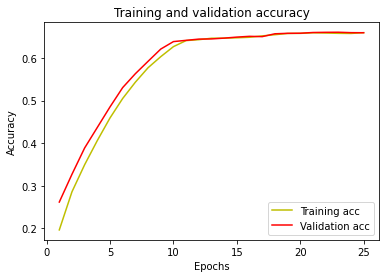

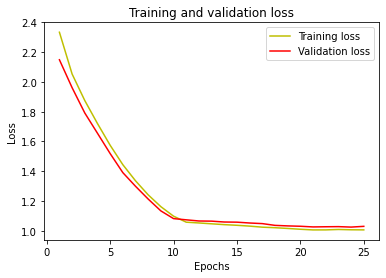

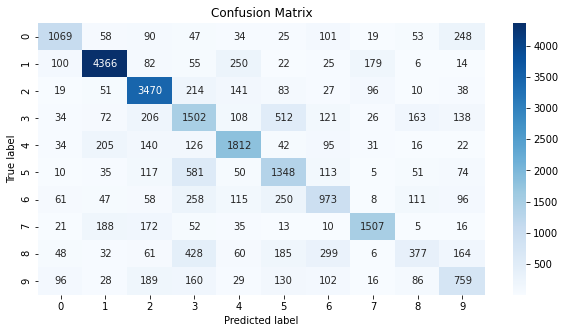

In [8]:
# Load a pretrained model
model_regnetx_002 = timm.create_model('regnetx_002', pretrained = True)

# Reset final fully connected layer and change the output size to 10
num_ftrs = model_regnetx_002.head.fc.in_features
num_output = 10
model_regnetx_002.head.fc = nn.Linear(num_ftrs, num_output)

model_regnetx_002 = model_regnetx_002.to(device)

# Use CrossEntropyLoss as criterion
criterion = nn.CrossEntropyLoss()
# Use SGD to optimize all parameters 
optimizer = optim.SGD(model_regnetx_002.parameters(), lr = 0.001)
# Decay LR by a factor of 0.1 every 10 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

epochs = 25
model_regnetx_002, train_acc, train_loss, validation_acc, validation_loss, time_hist = train_model(model_regnetx_002, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)
plot_stat(model_regnetx_002, epochs, train_acc, train_loss, validation_acc, validation_loss)

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
for i, model in enumerate([model_resnet18, model_densenet121, model_regnetx_002]):
  model_save_name = 'model' + str(i) + '.pt'
  path = F"/content/gdrive/My Drive/DL/{model_save_name}" 
  torch.save(model.state_dict(), path)